In [25]:
import datetime, time, os
import numpy as np
import pandas as pd

import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import layers
from tensorflow.keras import regularizers

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
    
print('Using TensorFlow version: %s' % tf.__version__)

RSEED = 1337

Using TensorFlow version: 2.8.0


In [26]:
!pip install -q git+https://github.com/tensorflow/docs
    
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

In [27]:
# Import Data

#data = pd.read_csv('data/data_prep_reg.csv', index_col=[0]) # includes the statistics of the features only location D
data = pd.read_csv('data/data_prep_feat.csv', index_col=[0]) # includes all values as a new features only location D
#data = pd.read_csv('data/data_prep_reg_all.csv', index_col=[0]) # include the statistics of the features an all locations

print(f'Data: {data.shape}')

Data: (4990, 770)


In [28]:
#fillna
data = data.fillna(data.mean())

In [29]:
data.head()

,location,target,max_temp,min_temp,mean_temp,std_temp,var_temp,median_temp,ptp_temp,max_precip,...,newrel_humidity119,newwind_dir119,windspeed119,atmospherepressure119,newtemp120,newprecip120,newrel_humidity120,newwind_dir120,windspeed120,atmospherepressure120
1,3,79.131702,33.616667,17.983333,24.679063,4.266955,18.206903,23.791667,15.633333,0.561,...,0.649250,73.528733,1.475833,90.439167,21.450000,0.561,0.797333,296.967254,1.019167,90.529167
10,3,55.638261,34.041667,17.191667,23.189507,4.432786,19.649595,22.033333,16.850000,10.302,...,0.759167,178.252679,0.896736,90.555833,20.491667,0.000,0.779958,177.704952,0.897390,90.531667
13,3,32.240851,29.608333,19.166667,23.151446,2.808773,7.889204,22.291667,10.441667,2.229,...,0.786333,101.535318,1.511667,90.554167,22.083333,2.229,0.915818,331.308648,1.970000,90.527500
15,3,72.717021,29.133333,17.516667,22.341529,3.161073,9.992384,21.683333,11.616667,13.588,...,0.871250,270.524749,0.454167,90.512500,19.716667,0.000,0.905083,231.191039,0.388333,90.477500
22,3,35.833571,30.558333,16.983333,22.401240,3.592899,12.908921,21.333333,13.575000,43.080,...,0.666833,178.252679,0.896736,90.239167,26.850000,0.000,0.642583,177.704952,0.897390,90.217500


In [30]:
columns_to_drop = list(data.columns)[2:44]
columns_to_drop.append('target')
columns_to_drop.append('location')

In [31]:
# = ['target', 'location', feature_stats]
# define features and target
X = data.drop(columns_to_drop, axis=1)
y = data.target

# test train split: 
X_train, X_test, y_train, y_test = train_test_split(  
                                    X, y, test_size = 0.3, 
                                    random_state = RSEED) 

print (f'X: {X.shape}')
print (f'y: {y.shape}')

print (f'X_train: {X_train.shape}')
print (f'y_train: {y_train.shape}')

print (f'X_test: {X_test.shape}')
print (f'y_test: {y_test.shape}')

X: (4990, 726)
y: (4990,)
X_train: (3493, 726)
y_train: (3493,)
X_test: (1497, 726)
y_test: (1497,)


In [32]:
X_train.head()

,newtemp0,newprecip0,newrel_humidity0,newwind_dir0,windspeed0,atmospherepressure0,newtemp1,newprecip1,newrel_humidity1,newwind_dir1,...,newrel_humidity119,newwind_dir119,windspeed119,atmospherepressure119,newtemp120,newprecip120,newrel_humidity120,newwind_dir120,windspeed120,atmospherepressure120
13500,19.775000,0.0,0.838083,324.758764,0.687500,90.472500,19.600000,0.0,0.856167,302.108490,...,0.960833,241.444055,0.367500,90.515000,23.341221,1.0,0.963333,193.867052,0.559167,90.512500
8672,19.358333,0.0,0.927500,304.130122,0.745000,90.329167,19.541667,0.0,0.899167,299.048574,...,0.885833,178.252679,0.896736,90.493333,19.083333,0.0,0.892750,177.704952,0.897390,90.475833
1509,23.075000,0.0,0.792833,60.592459,0.700000,90.690833,22.041667,0.0,0.835917,137.276479,...,0.828917,70.399998,2.082500,90.647500,21.391667,0.0,0.872583,123.593864,1.122500,90.755833
7952,28.300000,0.0,0.533333,20.530670,1.428333,90.226667,27.633333,0.0,0.539167,16.341283,...,0.866667,61.581591,0.442727,90.511667,20.827273,0.0,0.910909,177.704952,0.897390,90.514545
13557,23.391667,0.0,0.799583,107.678324,0.670833,90.881667,24.583333,0.0,0.775583,143.592868,...,0.702750,133.586469,0.820833,90.897500,26.783333,0.0,0.663583,127.686985,0.892500,90.835000


In [33]:
# pre selecting

N_VAL =  len(X_test)
N_TRAIN = len(X_train)
BATCH_SIZE = 96
STEPS_PER_EPOCH = N_TRAIN // BATCH_SIZE
EPOCHS = 5000

In [34]:
# preparation for Tensorboard

# Define path for new directory 
root_logdir = os.path.join(os.curdir, "my_logs")

# Define function for creating a new folder for each run
def get_run_logdir():
    run_id = time.strftime('run_%d_%m_%Y-%H_%M_%S')
    return os.path.join(root_logdir, run_id)
    
run_logdir = get_run_logdir()
#def get_callbacks():

def get_callbacks(name):
    return tf.keras.callbacks.TensorBoard(run_logdir+name, histogram_freq=1)

In [35]:
# checkpoint 

# Define path where checkpoints should be stored
checkpoint_path = "DNN/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=False,
                                                 verbose=1) # Set verbose != 0 if you want output during training


In [36]:
# Plotting function for MSE
def plot_metric(history):
    plt.plot(history.history['mse'])
    plt.plot(history.history['val_mse'])
    plt.title('Model MSE')
    plt.ylabel('MSE')
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()

In [37]:
# Plotting function for loss
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.title('Model Loss')
    plt.ylim([0, 10])
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)

In [38]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def error_analysis(y_test, y_pred_test):
    """Generated true vs. predicted values and residual scatter plot for models

    Args:
        y_test (array): true values for y_test
        y_pred_test (array): predicted values of model for y_test
    """     
    # Calculate residuals
    residuals = y_test - y_pred_test
    
    # Plot real vs. predicted values 
    fig, ax = plt.subplots(1,2, figsize=(15, 5))
    plt.subplots_adjust(right=1)
    plt.suptitle('Error Analysis')
    
    ax[0].scatter(y_pred_test, y_test, color="#FF5A36", alpha=0.7)
    ax[0].plot([-400, 350], [-400, 350], color="#193251")
    ax[0].set_title("True vs. predicted values", fontsize=16)
    ax[0].set_xlabel("predicted values")
    ax[0].set_ylabel("true values")
    #ax[0].set_xlim((y_pred_test.min()-10), (y_pred_test.max()+10))
    ax[0].set_ylim((y_test.min()-40), (y_test.max()+40))
    
    ax[1].scatter(y_pred_test, residuals, color="#FF5A36", alpha=0.7)
    ax[1].plot([-400, 350], [0,0], color="#193251")
    ax[1].set_title("Residual Scatter Plot", fontsize=16)
    ax[1].set_xlabel("predicted values")
    ax[1].set_ylabel("residuals")
    #ax[1].set_xlim((y_pred_test.min()-10), (y_pred_test.max()+10))
    #ax[1].set_ylim((residuals.min()-10), (residuals.max()+10));

In [39]:
def evaluate(model, model_history, X_test, y_test, X_train, y_train):
    # plot MSE history
    plot_metric(model_history)
    # plot loss history
    plot_loss(model_history)

    # evaluate the model:
    # Evaluate the small model on test set using .evaluate
    loss, mse = model.evaluate(X_test, y_test, verbose=2)
    print(f'Model MSE: {mse}')
    print('--------'*5)

    # Predict values for test set
    y_pred = model.predict(X_test)
    y_pred_train = model.predict(X_train)

    rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))

    test_results['first model'] =  [rmse_train, rmse_test]

    print('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred)))
    print('RMSE:', np.sqrt(mean_squared_error(y_train, y_pred_train)))

    fig, ax = plt.subplots(1,2, figsize=(15, 5))

    plt.subplots_adjust(right=1)
    plt.suptitle('Error Analysis')


    ax[0].scatter(y_pred, y_test, color="#FF5A36", alpha=0.7)
    ax[0].plot([-400, 350], [-400, 350], color="#193251")
    ax[0].set_title("True vs. predicted values", fontsize=16)
    ax[0].set_xlabel("predicted values")
    ax[0].set_ylabel("true values TEST")
    #ax[0].set_xlim((y_pred_test.min()-10), (y_pred_test.max()+10))
    ax[0].set_ylim((y_test.min()-40), (y_test.max()+40))

    ax[1].scatter(y_pred_train, y_test, color="#FF5A36", alpha=0.7)
    ax[1].plot([-400, 350], [-400, 350], color="#193251")
    ax[1].set_title("True vs. predicted values", fontsize=16)
    ax[1].set_xlabel("predicted values")
    ax[1].set_ylabel("true values Train")
    #ax[0].set_xlim((y_pred_test.min()-10), (y_pred_test.max()+10))
    ax[1].set_ylim((y_test.min()-40), (y_test.max()+40))
    pass

In [40]:
# Define dictionary to store results
training_history = {}
test_results = {}

In [41]:
def model_compile_and_fit(X, y, model, name, optimizer, max_epochs=30):
    # Get optimizer
    #optimizer=tf.keras.optimizers.Adam()

    # model.compile
    model.compile(optimizer=optimizer,
                metrics='mse', # [tf.keras.metrics.RootMeanSquaredError()]
                loss='mae')
    # model.fit
    training_history[name] = model.fit(X, 
                        y,
                        validation_split=0.2,
                        verbose=1,
                        steps_per_epoch=STEPS_PER_EPOCH,
                        epochs=EPOCHS, 
                        callbacks=get_callbacks(name))
    # return results
    return training_history[name]

In [42]:
with tf.device('/cpu:0'):
      all_features_model = tf.keras.Sequential([
            tf.keras.layers.Dense(512,kernel_initializer = 'uniform', activation='relu', input_dim = 726),
            tf.keras.layers.Dropout(0.25),
            tf.keras.layers.Dense(512,kernel_initializer = 'uniform', activation='relu'),
            tf.keras.layers.Dropout(0.25),
            tf.keras.layers.Dense(512,kernel_initializer = 'uniform', activation='relu'),
            tf.keras.layers.Dropout(0.25),
            tf.keras.layers.Dense(512,kernel_initializer = 'uniform', activation='relu'),
            tf.keras.layers.Dense(1,kernel_initializer = 'uniform')
      ])

In [43]:
with tf.device('/cpu:0'):
    all_features_model_history = model_compile_and_fit(X=X_train, 
                                            y=y_train,
                                            model= all_features_model,
                                            name='all_features_model',
                                            optimizer='Adam', 
                                            max_epochs= EPOCHS )

Epoch 1/5000
36/36 [==============================] - 1s 15ms/step - loss: 23.8299 - mse: 1128.0078 - val_loss: 20.4864 - val_mse: 959.3365
Epoch 2/5000
36/36 [==============================] - 0s 12ms/step - loss: 21.4562 - mse: 936.7535 - val_loss: 21.2189 - val_mse: 1033.1060
Epoch 3/5000
36/36 [==============================] - 0s 14ms/step - loss: 22.1124 - mse: 988.0870 - val_loss: 20.2603 - val_mse: 893.0325
Epoch 4/5000
36/36 [==============================] - 0s 11ms/step - loss: 22.1950 - mse: 987.5371 - val_loss: 21.8502 - val_mse: 1086.0934
Epoch 5/5000
36/36 [==============================] - 0s 9ms/step - loss: 21.3289 - mse: 944.7646 - val_loss: 25.3207 - val_mse: 1341.2537
Epoch 6/5000
36/36 [==============================] - 0s 9ms/step - loss: 21.6042 - mse: 958.6801 - val_loss: 21.7190 - val_mse: 1068.1678
Epoch 7/5000
36/36 [==============================] - 0s 8ms/step - loss: 21.5174 - mse: 932.7964 - val_loss: 24.3077 - val_mse: 1262.5236
Epoch 8/5000
36/36 [====

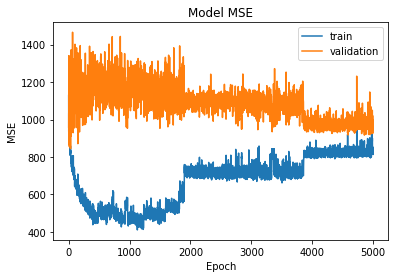

47/47 - 0s - loss: 21.9075 - mse: 1113.8529 - 109ms/epoch - 2ms/step
Model MSE: 1113.8529052734375
----------------------------------------
RMSE: 33.374433995217615
RMSE: 29.520435694163062


ValueError: x and y must be the same size

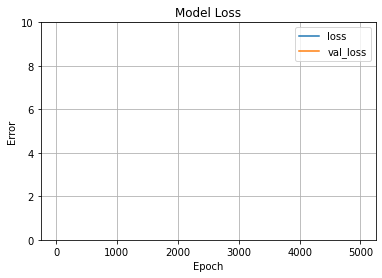

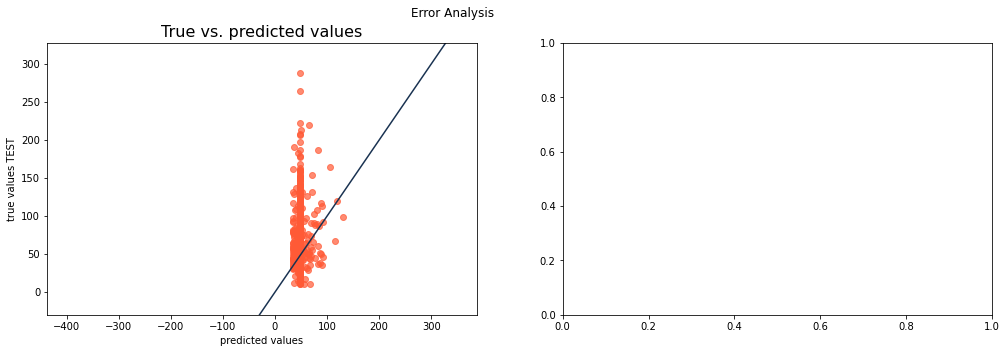

In [44]:
with tf.device('/cpu:0'):
    evaluate(all_features_model,all_features_model_history, X_test, y_test, X_train, y_train)

In [ ]:
# Save the entire small model as a SavedModel.
!mkdir -p saved_model
all_features_model.save('saved_model/dnn_model')

2022-04-08 15:52:22.548586: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: saved_model/dnn_model/assets


In [ ]:

training_history

In [ ]:


test_results